In [1]:
import tensorflow as tf
import tensorflow_io as tfio
import numpy as np
import csv
import io
import librosa
import matplotlib.pyplot as plt
import IPython.display as display
from IPython.display import Audio
from scipy.io import wavfile
import PIL.Image

In [2]:
import vggish_keras as vgk

In [3]:
compute = vgk.get_embedding_function(hop_duration=0.25)

In [4]:
content_layers = ['conv4/conv4_2'] 

style_layers = ['conv1',
                'conv2',
                'conv3/conv3_1', 
                'conv3/conv3_2', 
                'conv4/conv4_1']

In [5]:
def vgg_layers(layer_names):
    """ Creates a vgg model that returns a list of intermediate output values."""
    # Load our model. Load pretrained VGG, trained on imagenet data
    vgg = vgk.VGGish(include_top=False, weights='audioset')
    vgg.trainable = False
    #get activations from layers we're interested in
    outputs = [vgg.get_layer(name).output for name in layer_names]
    model = tf.keras.Model([vgg.input], outputs)
    return model

In [6]:
model = vgg_layers(content_layers+style_layers)

In [7]:
for layer in model.layers:
    print(layer.name)

input_1
conv1
pool1
conv2
pool2
conv3/conv3_1
conv3/conv3_2
pool3
conv4/conv4_1
conv4/conv4_2


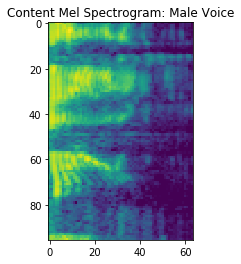

In [9]:
content_image = vgk.get_features(filename='ndgtyson.wav')
plt.title('Content Mel Spectrogram: Male Voice')
plt.imshow(content_image[0,:,:,0])

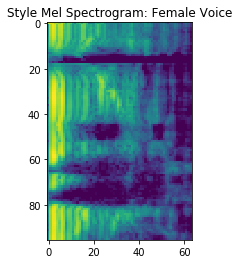

In [10]:
style_image = vgk.get_features(filename='nkminaj.wav')
plt.title('Style Mel Spectrogram: Female Voice')
plt.imshow(style_image[0,:,:,0],)

In [15]:
style_image.shape

(2, 96, 64, 1)

In [14]:
style_extractor = vgg_layers(style_layers)
style_outputs = style_extractor(style_image*255)

#Look at the statistics of each layer's output
for name, output in zip(style_layers, style_outputs):
    print(name)
    print("  shape: ", output.numpy().shape)
    print("  min: ", output.numpy().min())
    print("  max: ", output.numpy().max())
    print("  mean: ", output.numpy().mean())
    print()

conv1
  shape:  (2, 96, 64, 64)
  min:  0.0
  max:  8475.868
  mean:  1048.776

conv2
  shape:  (2, 48, 32, 128)
  min:  0.0
  max:  4524.4424
  mean:  543.4278

conv3/conv3_1
  shape:  (2, 24, 16, 256)
  min:  0.0
  max:  3721.7266
  mean:  329.79068

conv3/conv3_2
  shape:  (2, 24, 16, 256)
  min:  0.0
  max:  2362.9546
  mean:  238.33693

conv4/conv4_1
  shape:  (2, 12, 8, 512)
  min:  0.0
  max:  1672.4952
  mean:  138.05101



In [12]:
num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

In [13]:
def gram_matrix(input_tensor):
    result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
    input_shape = tf.shape(input_tensor)
    num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
    return result/(num_locations)

In [24]:
class StyleContentModel(tf.keras.models.Model):
    def __init__(self, style_layers, content_layers):
        super(StyleContentModel, self).__init__()
        self.vgg = vgg_layers(style_layers+content_layers)
        self.style_layers = style_layers
        self.content_layers = content_layers
        self.num_style_layers = len(style_layers)
        self.vgg.trainable = False 
        
    def call(self, inputs):
        """Expects float input in [0,1]"""
        outputs = self.vgg(inputs)
        style_outputs, content_outputs = (outputs[:self.num_style_layers], 
                                      outputs[self.num_style_layers:])
        style_outputs = [gram_matrix(style_output) for style_output in style_outputs]
        content_dict = {content_name:value for content_name,value in zip(self.content_layers, content_outputs)}
        style_dict = {
            style_name:value 
            for style_name, value
            in zip(self.style_layers, style_outputs)
        }
        return {'content': content_dict, 'style': style_dict}

In [25]:
extractor = StyleContentModel(style_layers, content_layers)

results = extractor(tf.constant(content_image))

print('Styles:')
for name, output in sorted(results['style'].items()):
    print("  ", name)
    print("    shape: ", output.numpy().shape)
    print("    min: ", output.numpy().min())
    print("    max: ", output.numpy().max())
    print("    mean: ", output.numpy().mean())
    print()

print("Contents:")
for name, output in sorted(results['content'].items()):
    print("  ", name)
    print("    shape: ", output.numpy().shape)
    print("    min: ", output.numpy().min())
    print("    max: ", output.numpy().max())
    print("    mean: ", output.numpy().mean())

Styles:
   conv1
    shape:  (1, 64, 64)
    min:  0.0
    max:  583.21515
    mean:  21.877138

   conv2
    shape:  (1, 128, 128)
    min:  0.0
    max:  152.97966
    mean:  5.429175

   conv3/conv3_1
    shape:  (1, 256, 256)
    min:  0.0
    max:  105.45453
    mean:  1.8355007

   conv3/conv3_2
    shape:  (1, 256, 256)
    min:  0.0
    max:  32.500286
    mean:  0.9594925

   conv4/conv4_1
    shape:  (1, 512, 512)
    min:  0.0
    max:  23.25132
    mean:  0.30096984

Contents:
   conv4/conv4_2
    shape:  (1, 12, 8, 512)
    min:  0.0
    max:  3.85629
    mean:  0.40477744


In [26]:
style_targets = extractor(style_image)['style']
content_targets = extractor(content_image)['content']

In [27]:
image = tf.Variable(content_image)

In [28]:
def clip_0_1(image):
    return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

In [29]:
opt = tf.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)

style_weight=1e-2
content_weight=1e4

def style_content_loss(outputs):
    style_outputs = outputs['style']
    content_outputs = outputs['content']
    style_loss = tf.add_n([tf.reduce_mean((style_outputs[name]-style_targets[name])**2) for name in style_outputs.keys()])
    content_loss = tf.add_n([tf.reduce_mean((content_outputs[name]-content_targets[name])**2) 
                             for name in content_outputs.keys()])
    content_loss *= content_weight / num_content_layers
    loss = style_loss + content_loss
    return loss

@tf.function()
def train_step(image):
    with tf.GradientTape() as tape:
        outputs = extractor(image)
        loss = style_content_loss(outputs)
    grad = tape.gradient(loss, image)
    opt.apply_gradients([(grad, image)])
    image.assign(clip_0_1(image))

In [71]:
def tensor_to_image(tensor):
    tensor = tensor*255
    tensor = np.array(tensor, dtype=np.uint8)
    if np.ndim(tensor)>3:
        assert tensor.shape[0] == 1
        tensor = tensor[0]
    print(tensor.shape)
    tensor = np.tile(tensor, 3)
    return tensor

In [69]:
def tensor_to_audio(tensor):
    tensor = tensor.numpy()
    if np.ndim(tensor)>3:
        assert tensor.shape[0] == 1
        tensor = tensor[0]
    tensor = tf.reduce_mean(tensor,axis=-1)
    audio_arr = librosa.feature.inverse.mel_to_audio(tensor.numpy().astype(np.float64), sr=16000, n_fft=400, hop_length=160, n_iter=64)
    return audio_arr

(96, 64, 1)


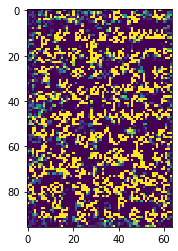

In [73]:
train_step(image)
train_step(image)
plt.imshow(tensor_to_image(image)[:,:,0])
Audio(tensor_to_audio(image), rate=16000)

<Figure size 432x288 with 0 Axes>

(96, 64, 1)


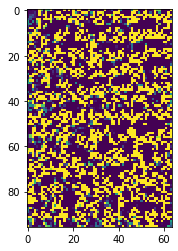

None

Train step: 1000
Total time: 152.4


In [75]:
import time
start = time.time()

epochs = 10
steps_per_epoch = 100

step = 0
for n in range(epochs):
    for m in range(steps_per_epoch):
        step += 1
        train_step(image)
        print(".", end='')
    display.clear_output(wait=True)
    display.display(plt.figure())
    display.display(plt.imshow(tensor_to_image(image)[:,:,0]))
    display.display(plt.show())
    display.display(Audio(tensor_to_audio(image), rate=16000))
    print("Train step: {}".format(step))

end = time.time()
print("Total time: {:.1f}".format(end-start))